# Imports

In [1]:
from classes import DataFile, DataOrganizer

# Load Data

In [2]:
organizer = DataOrganizer(2019)

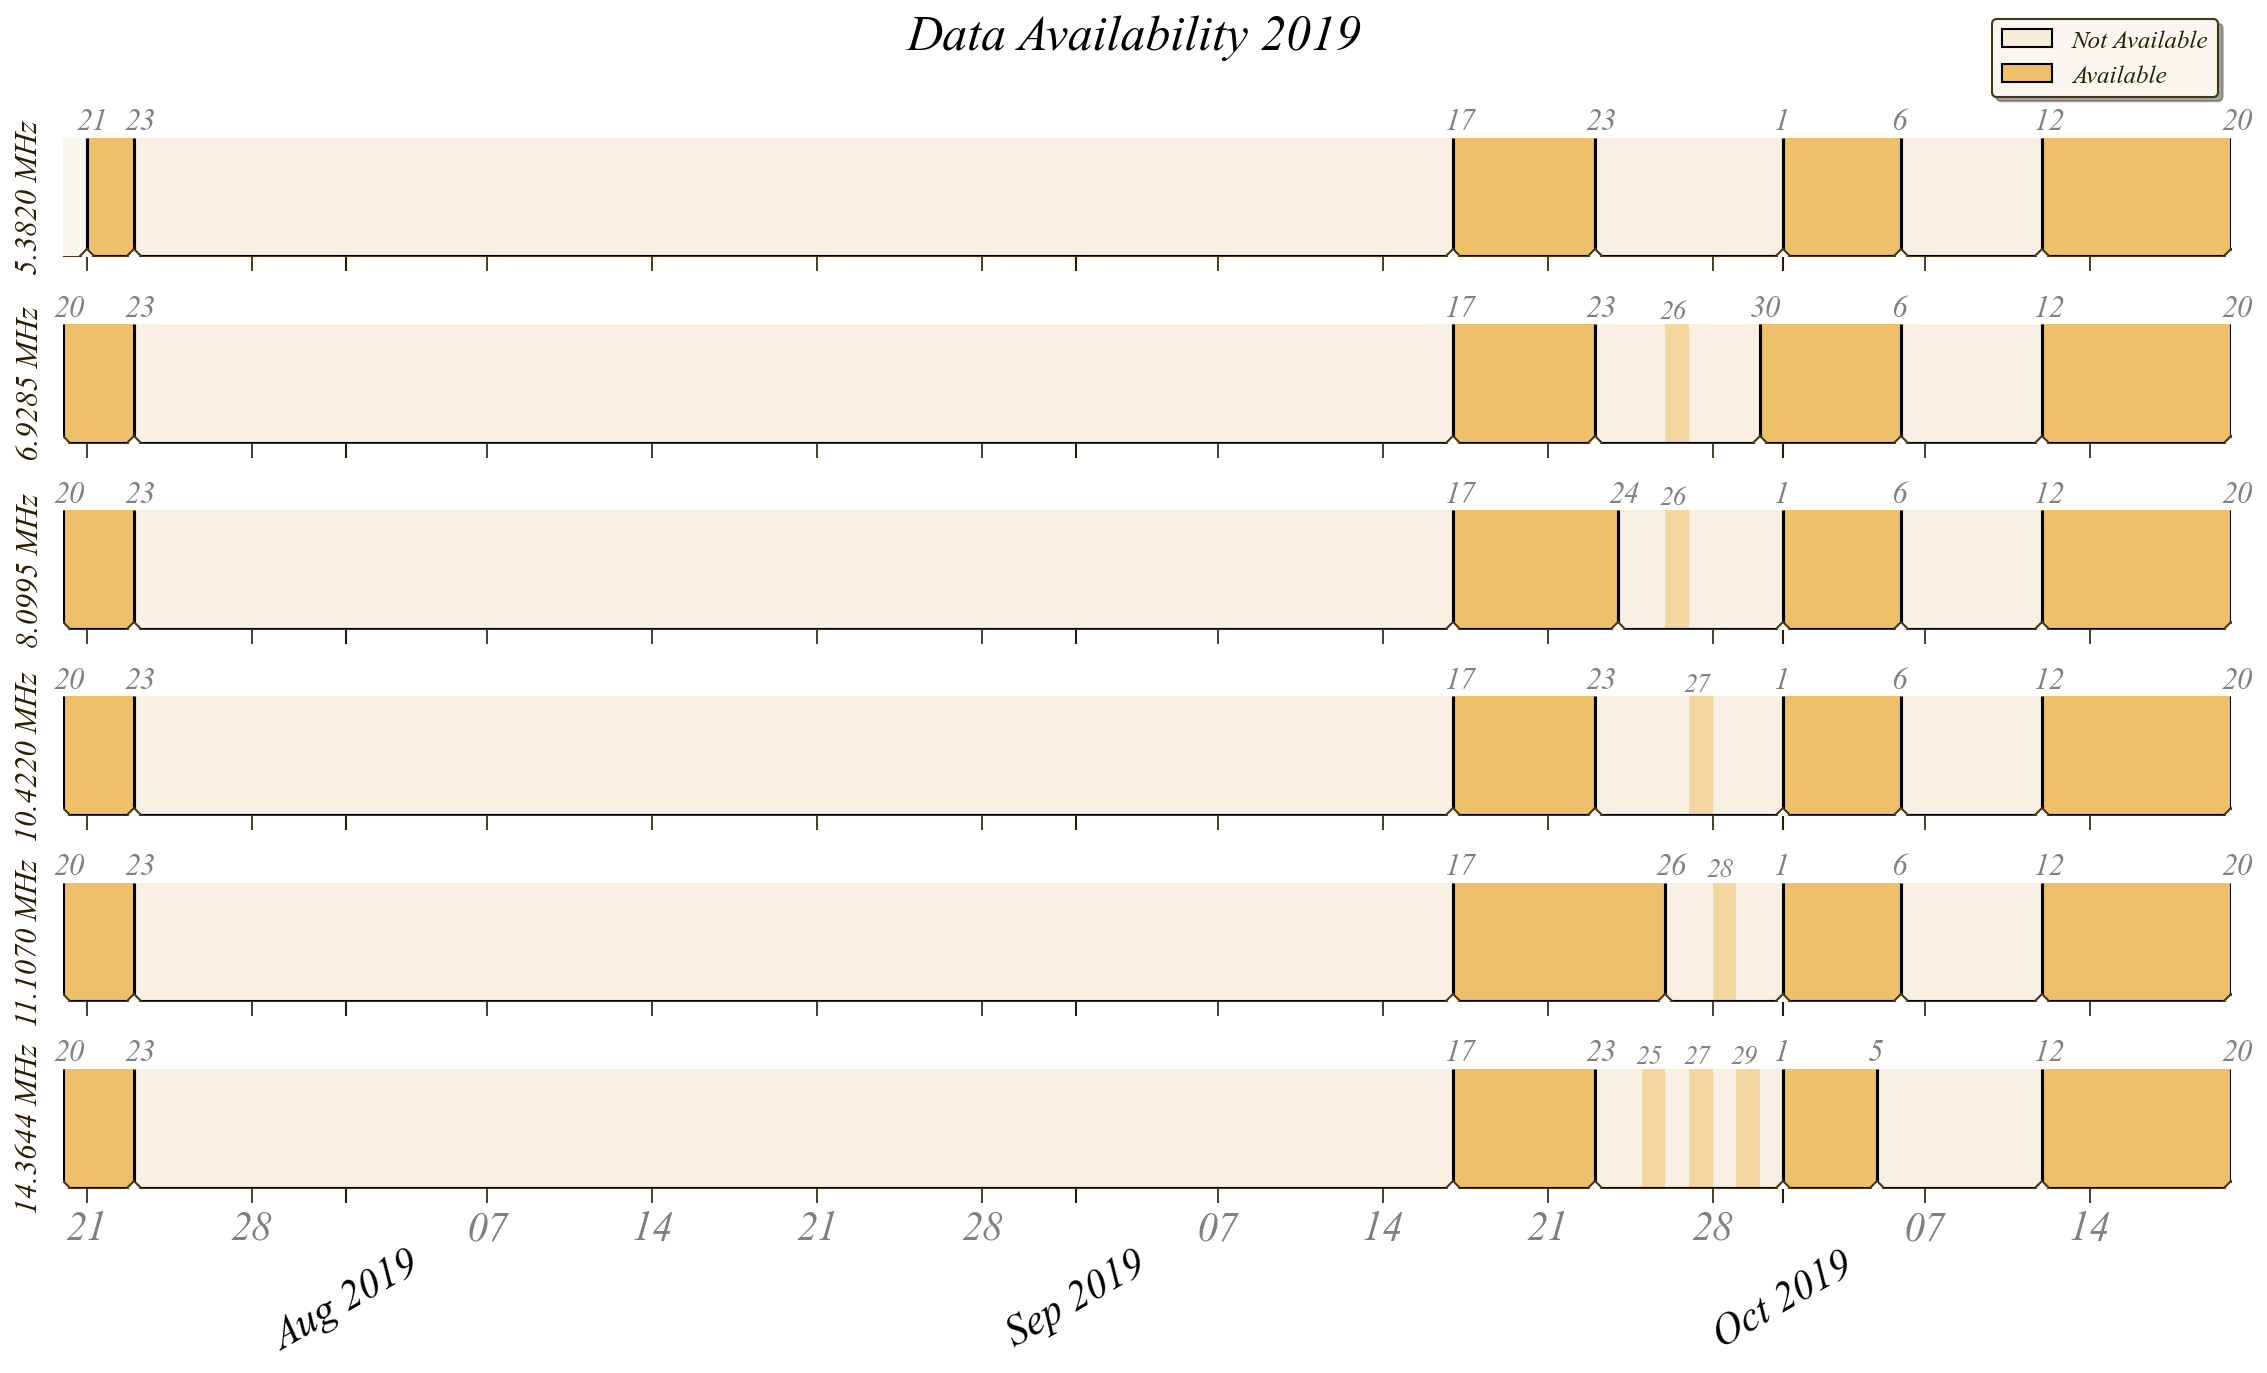

In [3]:
fig, axs = organizer.show_data_availability()

NameError: name 'np' is not defined